<a href="https://colab.research.google.com/github/azhgh22/Walmart-Recruiting-Store-Sales-Forecasting/blob/main/notebooks/statistical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import userdata
token = userdata.get('GITHUB_TOKEN')
user_name = userdata.get('GITHUB_USERNAME')
mail = userdata.get('GITHUB_MAIL')

!git config --global user.name "{user_name}"
!git config --global user.email "{mail}"
!git clone https://{token}@github.com/azhgh22/Walmart-Recruiting-Store-Sales-Forecasting.git

%cd Walmart-Recruiting-Store-Sales-Forecasting

Cloning into 'Walmart-Recruiting-Store-Sales-Forecasting'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 148 (delta 60), reused 145 (delta 57), pack-reused 0 (from 0)
Receiving objects: 100% (148/148), 6.15 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (60/60), done.
/content/Walmart-Recruiting-Store-Sales-Forecasting


In [3]:
from google.colab import userdata
!pip install -r requirements.txt
kaggle_json_path = userdata.get('KAGGLE_JSON_PATH')
! ./src/data_loader.sh -f {kaggle_json_path}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 65.9 MB/s eta 0:00:00
Setting up Kaggle credentials...
Ensuring data directory exists at 'data/'...
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 539MB/s]
Unzipping files...
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               
Data downloaded and extracted successfully to 'data/'.


## **Imports**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
from src.config import *

stores = pd.read_csv(STORES_PATH)
features = pd.read_csv(FEATURES_PATH)
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [54]:
train.groupby(['Store','Dept']).count()['Date']#[train.groupby(['Store','Dept']).count()['Date'] == 143]

Store  Dept
1      1       143
       2       143
       3       143
       4       143
       5       143
              ... 
45     94      134
       95      143
       96        2
       97      143
       98      135
Name: Date, Length: 3331, dtype: int64

In [63]:
train[['Store','Dept']].groupby(['Store']).nunique().sum()

,0
Dept,3331


In [144]:
train['Date'] = pd.to_datetime(train['Date'])

In [145]:
from src.dept_keeper import DeptKeeper
dept1 = DeptKeeper(train,SPLIT_DATE,1)

/tmp/ipython-input-8-1551910357.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', N)  # 20 distinct colors


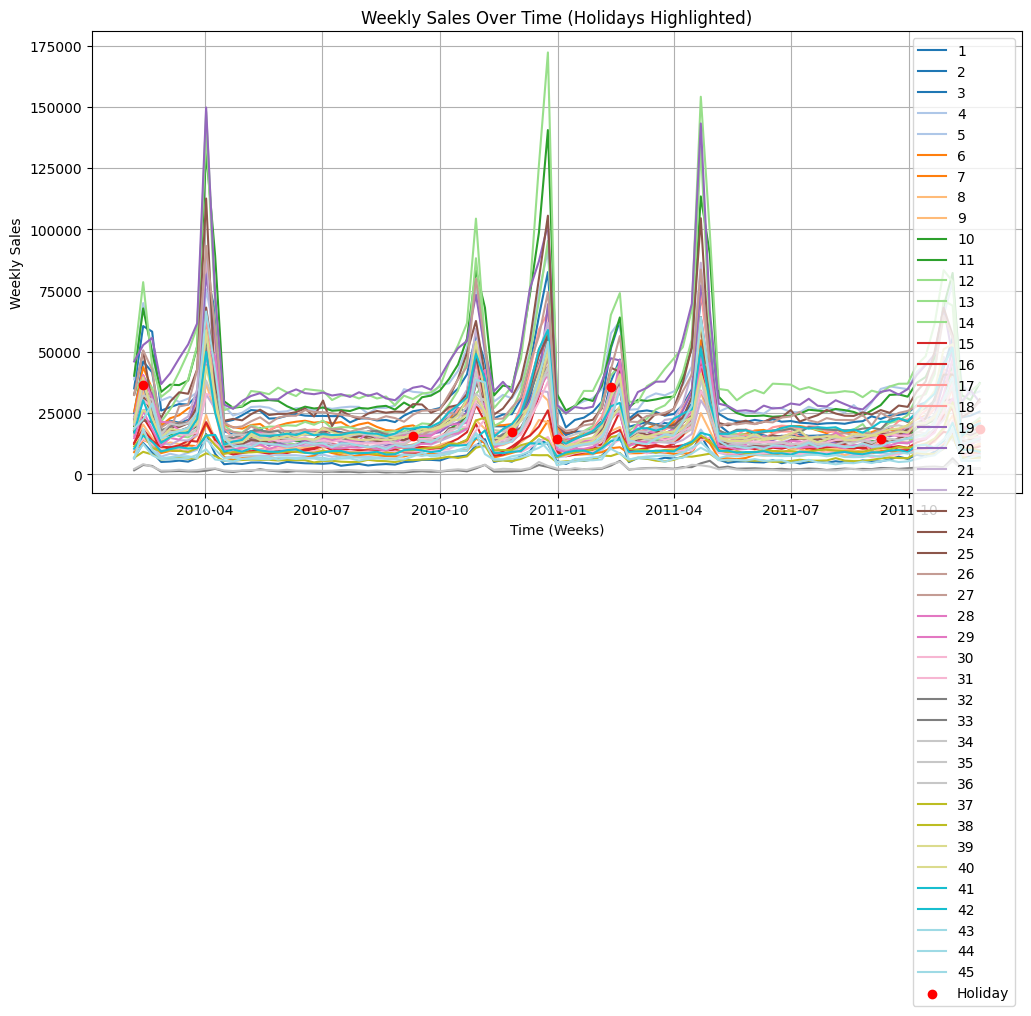

In [8]:
N = 45
cmap = plt.cm.get_cmap('tab20', N)  # 20 distinct colors

colors = [cmap(i) for i in range(N)]
holidays = dept1.get_train(22)[dept1.get_train(22)['IsHoliday'] == True]

plt.figure(figsize=(12, 6))
for s in sorted(dept1.get_train_keys()):
  plt.plot(dept1.get_train(s)['Date'], dept1.get_train(s)['Weekly_Sales'], label=f'{s}', color=colors[s-1])

plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)
plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

In [141]:
merged = dept1.get_train_avarage()

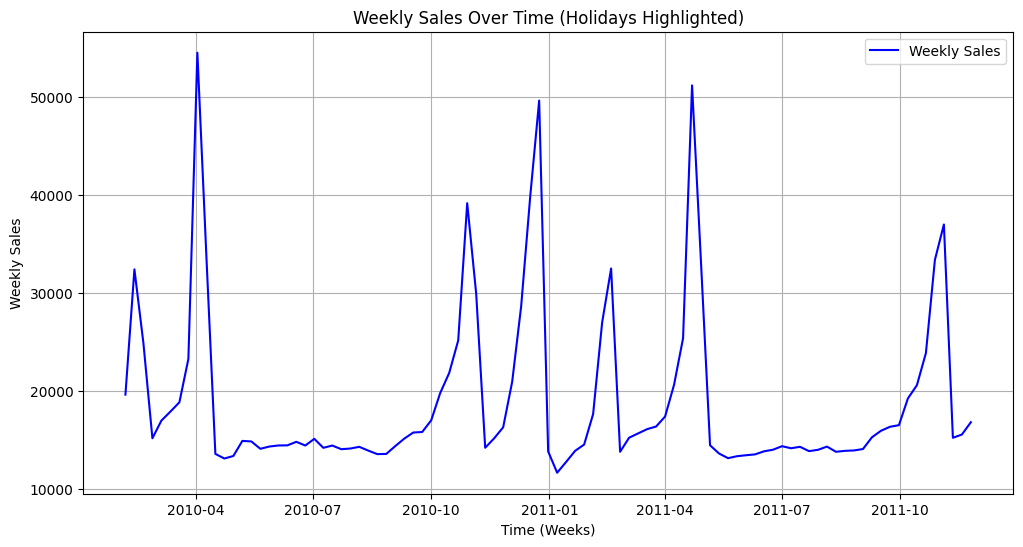

In [10]:
# holidays = dept1.get_train(1)[train_part['IsHoliday'] == True]

plt.figure(figsize=(12, 6))
plt.plot(merged['Date'], merged['Avg_Sales'], label='Weekly Sales', color='blue')
# plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)

plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(merged['Avg_Sales'].dropna())

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("✅ Series is likely stationary (reject H0)")
else:
    print("❌ Series is likely non-stationary (fail to reject H0)")

ADF Statistic: -6.28359107865509
p-value: 3.7446869343733156e-08
✅ Series is likely stationary (reject H0)


<Figure size 1000x500 with 0 Axes>

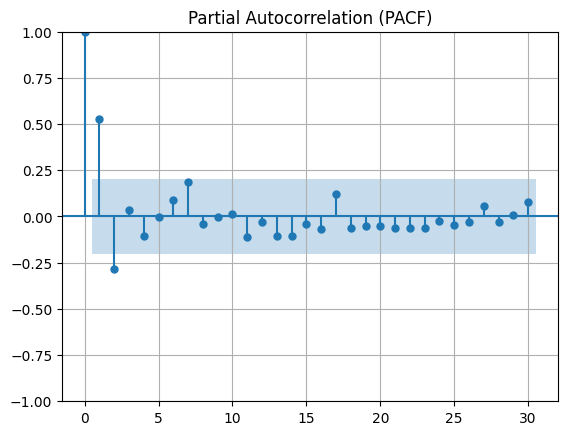

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 5))
plot_pacf(merged['Avg_Sales'], lags=30, method='ywm')  # or method='ld', 'ols', etc.
plt.title("Partial Autocorrelation (PACF)")
plt.grid(True)
plt.show()

In [120]:
from feature_engineering.time_features import FeatureAdder

def create_data(avarage:pd.DataFrame, one_of:pd.DataFrame)->pd.DataFrame:
    x = pd.DataFrame()

    x['lag1'] = avarage['Avg_Sales'].shift(1)
    x['lag2'] = avarage['Avg_Sales'].shift(2)
    x['Date'] = avarage['Date']
    x['Holiday'] = one_of['IsHoliday'].astype(int)
    # x['TimeDummy'] = one_of['DateDummy']
    # x['Year'] = one_of['Date'].dt.year
    # x['Month'] = one_of['Date'].dt.month
    # x.index = avarage['Date']

    x.bfill(inplace=True)

    y = avarage['Avg_Sales'].bfill()
    x = FeatureAdder().fit_transform(x)
    return x, y

In [121]:
x_train, y_train = create_data(dept1.get_train_avarage(), dept1.get_train(1))
x_val, y_val = create_data(dept1.get_val_avarage(), dept1.get_val(1))

In [90]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from src.utils import *

In [149]:
model = XGBRegressor(
    n_estimators=1950,
    learning_rate=0.001,
    max_depth=5,
    objective='reg:squarederror',
    random_state=42,
)

model.fit(x_train, y_train,
          eval_set=[(x_train, y_train), (x_val, y_val)],
        verbose=False)

y_train_predict = model.predict(x_train)
y_val_predict = model.predict(x_val)
# train_score = mean_absolute_error(y_train, y_train_predict)
# val_score = mean_absolute_error(y_val, y_val_predict)
train_score = wmae(y_train, y_train_predict,x_train['Holiday'].to_list())
val_score = wmae(y_val, y_val_predict,x_val['Holiday'].to_list())
print(f"Train MSE: {train_score}, Val MSE: {val_score}")

Train MSE: 1444.4835246710522, Val MSE: 5267.963063151042


In [151]:
departments = pd.unique(train['Dept'])
# for d in
train_sum = 0
val_sum = 0
for d in departments:
  dept = DeptKeeper(train,SPLIT_DATE,d)
  x_train, y_train = create_data(dept.get_train_avarage(), dept.get_train(1))
  x_val, y_val = create_data(dept.get_val_avarage(), dept.get_val(1))
  model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.001,
    max_depth=5,
    objective='reg:squarederror',
    random_state=42,
  )
  model.fit(x_train, y_train,
          eval_set=[(x_train, y_train), (x_val, y_val)],
        verbose=False)
  y_train_predict = model.predict(x_train)
  y_val_predict = model.predict(x_val)
  train_score = wmae(y_train, y_train_predict,x_train['Holiday'].to_list())
  val_score = wmae(y_val, y_val_predict,x_val['Holiday'].to_list())
  train_sum += train_score
  val_sum += val_score
  print(f"dep: {d}",f"Train MSE: {train_score}, Val MSE: {val_score}")
print(f"Train MSE: {train_sum/len(departments)}, Val MSE: {val_sum/len(departments)}")

dep: 1 Train MSE: 1256.6989441550932, Val MSE: 1689.6474246961798
dep: 2 Train MSE: 648.41541736111, Val MSE: 1496.161768952547
dep: 3 Train MSE: 937.7485850557382, Val MSE: 1588.109920093677
dep: 4 Train MSE: 351.7440414290937, Val MSE: 955.5159894024885
dep: 5 Train MSE: 1602.9977435912822, Val MSE: 4691.914867151329
dep: 6 Train MSE: 335.1271492853309, Val MSE: 1378.4478104163559
dep: 7 Train MSE: 2062.2865167489026, Val MSE: 4265.113632071035
dep: 8 Train MSE: 485.48597874634527, Val MSE: 1119.2912684823493


/content/Walmart-Recruiting-Store-Sales-Forecasting/src/dept_keeper.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Weekly_Sales': f'Sales{i+1}'}, inplace=True)


dep: 9 Train MSE: 972.4787362667371, Val MSE: 1852.9834830895104
dep: 10 Train MSE: 315.47998876096494, Val MSE: 871.3516194661463
dep: 11 Train MSE: 659.696743131147, Val MSE: 1077.2459340820312
dep: 12 Train MSE: 105.66575882750773, Val MSE: 181.42075954861096
dep: 13 Train MSE: 419.9950489766079, Val MSE: 808.3498668619798
dep: 14 Train MSE: 631.5646898300438, Val MSE: 1183.9389002459493
dep: 16 Train MSE: 1466.5063856451027, Val MSE: 1766.3288579101559
dep: 17 Train MSE: 295.6691886936803, Val MSE: 626.0799940797951
dep: 18 Train MSE: 1246.1927947300853, Val MSE: 1665.9196101714965
dep: 19 Train MSE: 55.78804344169843, Val MSE: 138.48401114210486
dep: 20 Train MSE: 151.20097669870484, Val MSE: 315.81083423256797
dep: 21 Train MSE: 138.728184950658, Val MSE: 342.78333125361706
dep: 22 Train MSE: 394.95521198210673, Val MSE: 1083.7600769590854
dep: 23 Train MSE: 1232.1236386351834, Val MSE: 2107.321251979881
dep: 24 Train MSE: 401.11241620561293, Val MSE: 630.2866615293871
dep: 25 Tr

/content/Walmart-Recruiting-Store-Sales-Forecasting/src/dept_keeper.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Weekly_Sales': f'Sales{i+1}'}, inplace=True)


dep: 30 Train MSE: 118.27381031905665, Val MSE: 410.84507645890517
dep: 31 Train MSE: 132.6964874321935, Val MSE: 312.40938237431016
dep: 32 Train MSE: 475.31609795084427, Val MSE: 889.0999630668317
dep: 33 Train MSE: 392.96073874823793, Val MSE: 701.56012366171
dep: 34 Train MSE: 535.276157694596, Val MSE: 1195.9931532307135
dep: 35 Train MSE: 115.01039491779535, Val MSE: 287.9302575931034
dep: 36 Train MSE: 196.2577615519806, Val MSE: 329.25883437496975
dep: 37 Train MSE: 56.40102687786146, Val MSE: 114.82030210141781
dep: 38 Train MSE: 1065.9608169590647, Val MSE: 3101.0222649016196
dep: 40 Train MSE: 455.68328841374256, Val MSE: 1604.0839237557875
dep: 41 Train MSE: 160.41030052885807, Val MSE: 242.37617124876706
dep: 42 Train MSE: 80.77891035759204, Val MSE: 361.4722569674611
dep: 44 Train MSE: 172.02633782810693, Val MSE: 334.68693769149166
dep: 45 Train MSE: 2.8657153347048183, Val MSE: 5.9181205511371555
dep: 46 Train MSE: 431.85334393274866, Val MSE: 1105.2026178385406
dep: 47

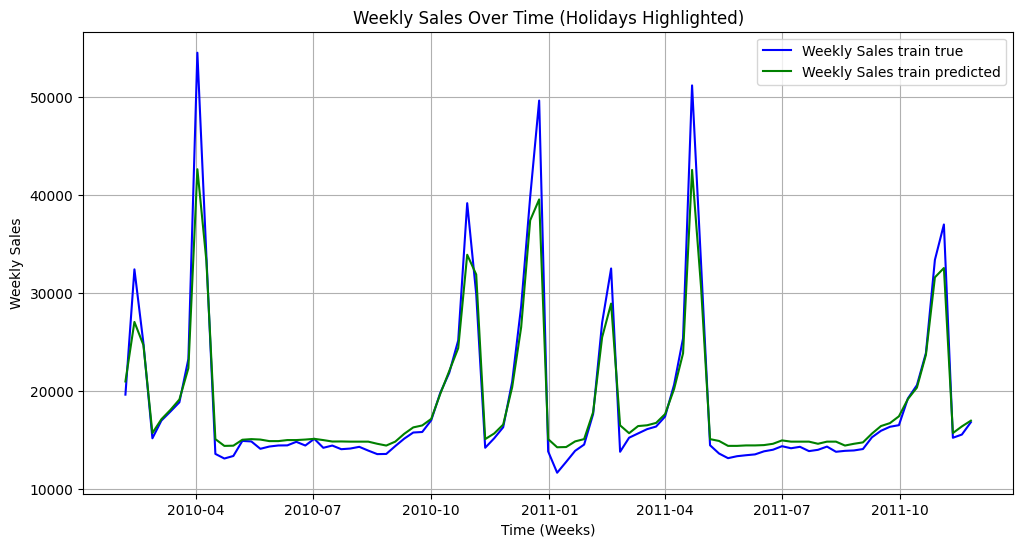

In [102]:
plt.figure(figsize=(12, 6))
plt.plot(merged['Date'], merged['Avg_Sales'], label='Weekly Sales train true', color='blue')
plt.plot(merged['Date'], y_train_predict, label='Weekly Sales train predicted', color='green')
# plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)

plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()

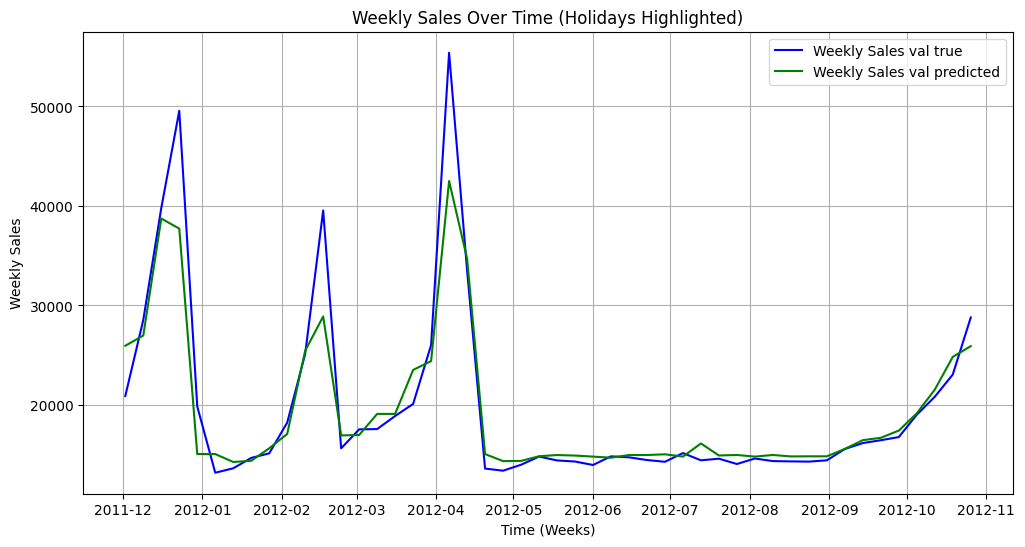

In [103]:
val_avaraged = dept1.get_val_avarage()

plt.figure(figsize=(12, 6))
plt.plot(dept1.get_val(1)['Date'], val_avaraged['Avg_Sales'], label='Weekly Sales val true', color='blue')
plt.plot(dept1.get_val(1)['Date'], y_val_predict, label='Weekly Sales val predicted', color='green')
# plt.scatter(holidays['Date'], holidays['Weekly_Sales'], color='red', label='Holiday', zorder=5)

plt.title("Weekly Sales Over Time (Holidays Highlighted)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()